In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_1348\906459842.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
data = pd.read_csv("../FFN/mnist_train_small.csv", header=None)

# extract labels (number ID's) and remove from data
labels = data.values[:, 0]  # Convert DataFrame to NumPy before slicing
data = data.values[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

In [3]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [4]:
# creating a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = .01)

    return net, lossfun, optimizer

In [5]:
 # train the model

def trainTheModel(net, lossfun, optimizer):

    # training parameter
    numepochs = 10
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):

        # switch on train mode
        net.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad():
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [6]:
import time

# range of std's to use
stdevs = np.logspace(np.log10(.0001), np.log10(10), 25)

# number of histogram bins for plotting distributions
nhistBins = 80

# initialize results output matrix
accresults = np.zeros(len(stdevs))
histodata = np.zeros((len(stdevs), 2, nhistBins))

# start the timer
startTime = time.process_time()

# start experiment
for idx, std in enumerate(stdevs):

    # create the network
    net, lossfun, optimizer = createTheMNISTNet()

    # set all parameters according to the std
    for p in net.named_parameters():
        p[1].data = torch.randn_like(p[1].data) * std

    # train the model
    trainAcc, testAcc, losses, net = trainTheModel(net, lossfun, optimizer)

    # get test accuracy on final 3 runs (averaging increases stability)
    accresults[idx] = np.mean(testAcc[-3:])

    # collect all parameters into one vector and compute its histogram
    tmpparams = np.array([])
    for p in net.named_parameters():
        tmpparams = np.concatenate((tmpparams, p[1].data.numpy().flatten()), axis = 0)

    # now compute their histogram
    y,x = np.histogram(tmpparams,nhistBins)
    histodata[idx,0,:] = (x[1:]+x[:-1])/2
    histodata[idx,1,:] = y
    
    # status report
    timeElapsed = time.process_time() - startTime
    print(f'Finished {idx+1}/{len(stdevs)} after {timeElapsed:3.0f}s. Model accuracy was {accresults[idx]:.2f}%.')

Finished 1/25 after  62s. Model accuracy was 93.18%.
Finished 2/25 after 119s. Model accuracy was 93.27%.
Finished 3/25 after 182s. Model accuracy was 93.38%.
Finished 4/25 after 241s. Model accuracy was 93.80%.
Finished 5/25 after 298s. Model accuracy was 94.08%.
Finished 6/25 after 355s. Model accuracy was 93.67%.
Finished 7/25 after 412s. Model accuracy was 94.12%.
Finished 8/25 after 478s. Model accuracy was 94.38%.
Finished 9/25 after 536s. Model accuracy was 93.97%.
Finished 10/25 after 593s. Model accuracy was 94.37%.
Finished 11/25 after 654s. Model accuracy was 93.33%.
Finished 12/25 after 713s. Model accuracy was 94.72%.
Finished 13/25 after 767s. Model accuracy was 94.50%.
Finished 14/25 after 836s. Model accuracy was 94.60%.
Finished 15/25 after 914s. Model accuracy was 94.38%.
Finished 16/25 after 975s. Model accuracy was 94.58%.
Finished 17/25 after 1039s. Model accuracy was 94.68%.
Finished 18/25 after 1092s. Model accuracy was 93.95%.
Finished 19/25 after 1145s. Model a

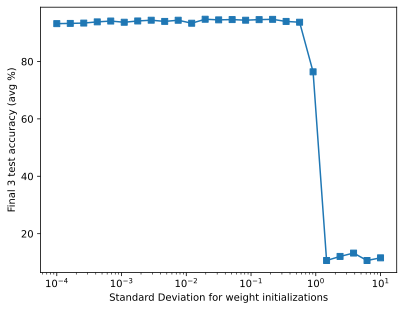

In [8]:
# show the results
plt.plot(stdevs, accresults, "s-")
plt.xlabel("Standard Deviation for weight initializations")
plt.ylabel("Final 3 test accuracy (avg %)")
plt.xscale("log")
plt.show()

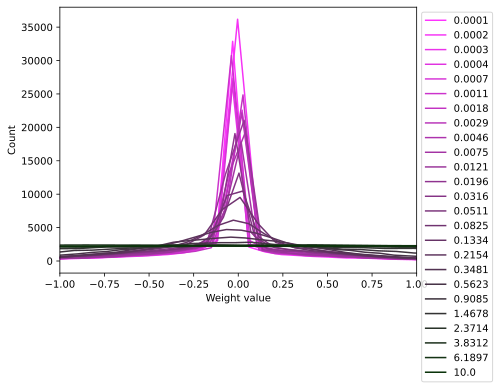

In [9]:
# show the weights distributions

for i in range(len(stdevs)):
  plt.plot(histodata[i,0,:],histodata[i,1,:],color=[1-i/len(stdevs),.2,1-i/len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1),loc='upper left')
plt.xlim([-1,1])
plt.show()